In [21]:
import meanreversion as mr
import numpy as np
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


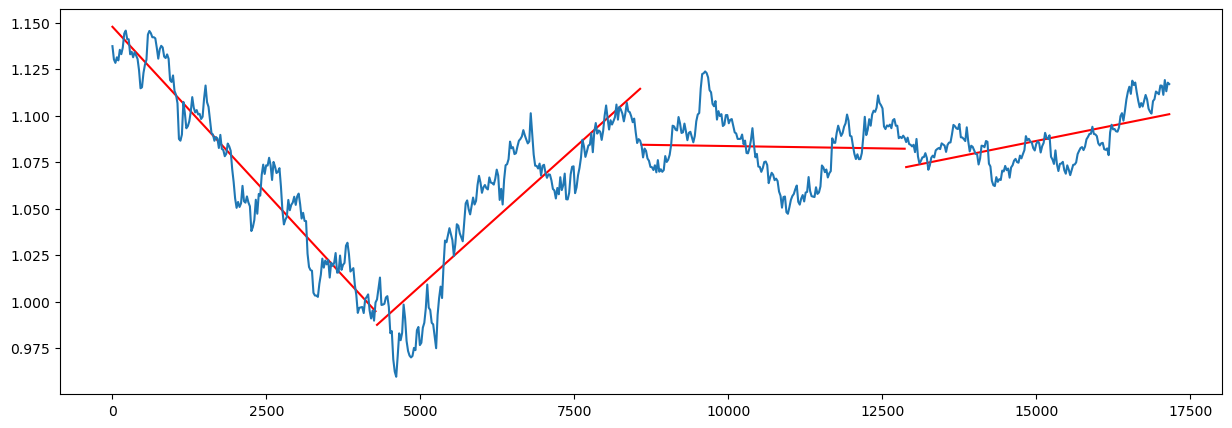

In [53]:
data = mr.download_asset("EURUSD=X", start='2022-01-01',end='2024-10-01')
mesh = np.linspace(0, len(data), 5)

#data = mr.load_asset("data/DAX_M15_202005242300_202411131015.csv")
#mesh = np.array([0,int(len(data)/4), int(len(data)/2), int(len(data))])

mesh = np.linspace(0, len(data), 5)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot()
slices = mr.removeTrend(data, mesh, ax)
ax.plot(data.index, data["Close"])
plt.show()

Periods:  0.6067415730337079
Amplitudes:  0.28361122292883784


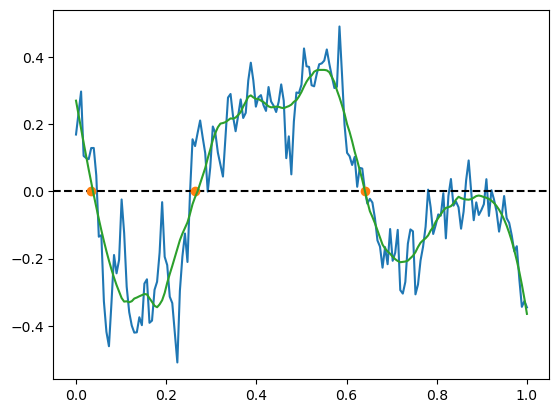

In [159]:
# TODO: extrapolate functions to meanreversion.py

x = slices[1].to_numpy()
t = slices[1].index.to_numpy()

t = (t - t.min()) / (t.max()-t.min())   # Normalize time values to [0, 1]
x = x / (x.max()-x.min())   # Normalize price values to [0, 1]

from scipy.signal import savgol_filter, find_peaks
x_filtered = savgol_filter(x, window_length=len(x)//5, polyorder=3)


periods = mr.find_periods(t, x_filtered)
peaks = mr.find_amplitudes(t, x_filtered)

print("Periods: ", np.mean(periods))
print("Amplitudes: ", np.mean(peaks))

plt.plot(t, x)
plt.axhline(0, color='black', linestyle='--')
plt.plot(mr.find_zeros(t, x_filtered), np.zeros(len(mr.find_zeros(t, x_filtered))), 'o')
plt.plot(t, x_filtered)
plt.show()


In [160]:
from scipy.fftpack import fft, fftfreq, ifft


period_fft, phase_fft = mr.find_period_fft(t, x_filtered)
print("Period via FFT: ", period_fft)
print("Phase via FFT: ", phase_fft)

Period via FFT:  0.4309791332263242
Phase via FFT:  -0.642897810956203


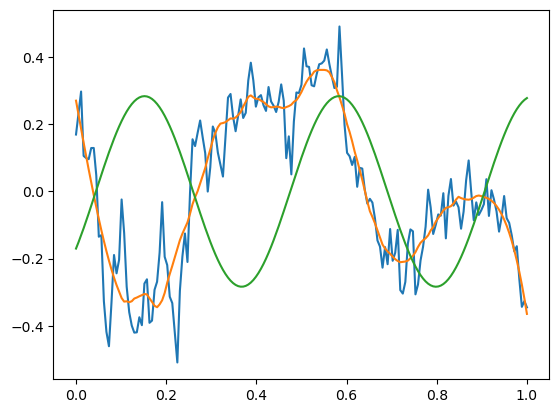

In [161]:
plt.plot(t, x)
plt.plot(t, x_filtered)
plt.plot(t, peaks.mean()*np.sin(2*np.pi*t/period_fft + phase_fft))
plt.show()

## Maximum Likelihood estimation to find volatility
As probability, we aproximate the propagator with a gaussian (we should solve the Fokker-Planck equation)

$$dx(t)=f(x,t,\boldsymbol{\theta})dt+g(x,t,\boldsymbol{\theta})dB(t)$$

$$p_{\boldsymbol{\theta}}(x,t|y)\simeq\mathcal{N}_y(x+f(x,t,\boldsymbol{\theta})t, tg^2(x,t,\boldsymbol{\theta}))$$

$$\mathcal{L}(x,t,\boldsymbol{\theta})=\prod p_{\boldsymbol{\theta}}(x,t|y)$$

$$\boldsymbol{\theta}=\arg\max_{\boldsymbol{\theta}}\mathcal{L}(x,t,\boldsymbol{\theta})$$
As minimization in quite unstable, we use the previously founded phase $\varphi$, amplitude $A$ and frequency $\omega=2\pi/T$ as exact values. We use the Ornstein Uhlenbeck process as SDE and the following functions as model:
$$f(x,t,\boldsymbol{\theta})=\theta(A\sin(\omega t+\varphi)-x)$$
$$f(x,t,\boldsymbol{\theta})=\sigma$$
The parameters to be estimated are only $\boldsymbol{\theta}=\{\theta, \sigma\}$ where $\theta$ give the Ornstein Uhlenbeck "speed" and $\sigma$ give information about volatility of the price. As mean reversion metric we can choose the ratio between amplitude and volatility: if the amplitude of the oscillation is bigger than the random fluctuation, then we have a mean reversion dynamic.
$$MRI=\frac{A}{\sigma}$$
if $MRI$ (Mean Reversion Index) is significally bigger than one, then is more likely that we have mean reversion.

In [162]:
# to simplify the minimization process we assume that the period and amplitude are known from the previous calculation
amplitude = np.mean(peaks)
frequency = 2*np.pi / ((np.mean(periods) + period_fft)/2)
print("Amplitude: ", amplitude)
print("Frequiency: ", frequency)

# Define the SDE
def f(t, x, params):
    omega, phi, theta, _ = params
    A = amplitude
    return theta * (A*np.sin(omega*t + phi) - x) + A*omega*np.cos(omega*t + phi)

def g(x, params):
    return params[3]

from scipy.optimize import minimize
bounds = ((0, None), (-2*np.pi, 2*np.pi), (1e-3, None), (0.0, None))  # bounds for the parameters
guess = [frequency, phase_fft, 1.0, 1.0]
print("\nInitial guess: ", guess)

res = minimize(mr.log_likelihood, guess, args=(x_filtered, t, f, g), method='L-BFGS-B', options={'disp': False, 'ftol': 1e-6}, bounds=bounds)
omega_val, phi_val, theta_val, sigma_val = res.get('x')

print("Optimal parameters: ", res.get('x'))
print(f"\nVolatility: {sigma_val:.4}")
print(f"Amplitude-volatility ratio: {amplitude/sigma_val:.4}")
print(f"Ornstein-Uhlenbeckrn half-life {np.log(2)/theta_val:.4}")

Amplitude:  0.28361122292883784
Frequiency:  12.109588387851145

Initial guess:  [12.109588387851145, -0.642897810956203, 1.0, 1.0]
Optimal parameters:  [ 1.36746829e+01 -4.62539096e+00  1.00000000e-03  2.44163611e-01]

Volatility: 0.2442
Amplitude-volatility ratio: 1.162
Ornstein-Uhlenbeckrn half-life 693.1


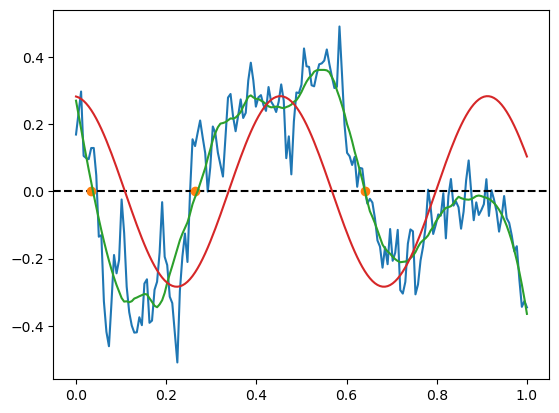

In [163]:
plt.plot(t, x)
plt.axhline(0, color='black', linestyle='--')
plt.plot(mr.find_zeros(t, x_filtered), np.zeros(len(mr.find_zeros(t, x_filtered))), 'o')
plt.plot(t, x_filtered)
plt.plot(t, amplitude*np.sin(t*omega_val+phi_val))
plt.show()

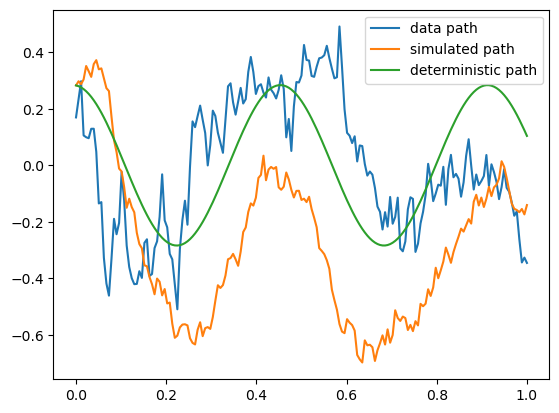

In [170]:
mu = lambda t, x : theta_val * (amplitude*np.sin(omega_val*t + phi_val) - x) + amplitude*omega_val*np.cos(omega_val*t + phi_val)
sigma = lambda t, x : sigma_val*2

np.random.seed(42)

X = mr.SDE_solver(x0=amplitude*np.sin(phi_val), t0=0.0, T=1.0, dt=(t[1]-t[0]), mu=mu, sigma=sigma)

plt.plot(t, x, label='data path')
plt.plot(t, X, label='simulated path')
plt.plot(t, amplitude*np.sin(t*omega_val+phi_val), label='deterministic path')
plt.legend()
plt.show()